In [37]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import matplotlib.pyplot as plt

In [38]:
# 读取 npz 文件
data = np.load('data.npz', allow_pickle=True)
print(list(data.keys()))

['x', 'y', 'edge_type', 'edge_index', 'train_mask', 'test_mask']


In [39]:
with open("extended_graphs_data.pkl", "rb") as file:
    data = pickle.load(file)
    file.close()

In [40]:
print(data)

Data(x=[579157, 32], edge_index=[2, 335118], edge_attr=[335118], y=[579157], train_mask=[32342], valid_mask=[8086], test_mask=[193053], edge_direct=[335118])


In [41]:
# 获取数据
x = data['x']
y = data['y']
edge_index = data['edge_index']
# edge_type = data['edge_type']
edge_type = data['edge_attr']
# edge_timestamp = data['edge_timestamp']
train_mask = data['train_mask']
test_mask = data['test_mask']
val_mask = data['valid_mask']

# 输出数据的形状
print("x shape:", x.shape)
print("y shape:", y.shape)
print("edge_index shape:", edge_index.shape)
print("edge_type shape:", edge_type.shape)
# print("edge_timestamp shape:", edge_timestamp.shape)
print("train_mask shape:", train_mask.shape)
print("test_mask shape:", test_mask.shape)

x shape: torch.Size([579157, 32])
y shape: torch.Size([579157])
edge_index shape: torch.Size([2, 335118])
edge_type shape: torch.Size([335118])
train_mask shape: torch.Size([32342])
test_mask shape: torch.Size([193053])


In [42]:
edge_index

tensor([[205686, 469991, 412851,  ..., 411829, 276549, 577465],
        [359744, 488834, 463368,  ..., 104931,  33545, 210486]])

In [43]:
edge_type

tensor([ 5,  6, 11,  ..., 11, 11,  9])

In [44]:
x

tensor([[ 0.0000,  6.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  5.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000,  4.0000, -1.0000,  ...,  0.0000,  1.0000,  0.9243],
        [ 0.0000,  3.0000, -1.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0000,  4.0000,  1.0100,  ...,  0.0000,  0.0000,  0.0000]])

In [45]:
y

tensor([   1,    1,    1,  ...,    0, -100,    0])

In [46]:
print(np.sum(y.cpu().numpy() == -100))
print(np.sum(y.cpu().numpy() == 1))
print(np.sum(y.cpu().numpy() == 0))

193053
4492
381612


In [47]:
from sklearn.model_selection import train_test_split

# 根据 train_mask 和 test_mask 划分数据
X_train = x[train_mask]
y_train = y[train_mask]
X_test = x[test_mask]
y_test = y[test_mask]
X_val = x[val_mask]
y_val = y[val_mask]

# 将 X_train 进一步划分为训练集和验证集
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 输出各数据集的形状
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([32342, 32])
y_train shape: torch.Size([32342])
X_val shape: torch.Size([8086, 32])
y_val shape: torch.Size([8086])
X_test shape: torch.Size([193053, 32])
y_test shape: torch.Size([193053])


In [48]:
print("train")
print('1: ', np.sum(y_train.cpu().numpy() == 1), ' 0: ', np.sum(y_train.cpu().numpy() == 0))
print("val")
print('1: ', np.sum(y_val.cpu().numpy() == 1), ' 0:  ', np.sum(y_val.cpu().numpy() == 0))

train
1:  3616  0:  28726
val
1:  876  0:   7210


In [49]:
'''
print("train")
print('1: ', np.sum(y_train == 1), ' 0: ', np.sum(y_train == 0))

from imblearn.under_sampling import NearMiss
trans = NearMiss(version=3)
X_resampled, y_resampled = trans.fit_resample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={0: np.sum(y_train == 1) * 3}, random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(X_resampled.shape)
print(y_resampled.shape)
print('1: ', np.sum(y_resampled == 1), ' 0: ', np.sum(y_resampled == 0))
'''

'\nprint("train")\nprint(\'1: \', np.sum(y_train == 1), \' 0: \', np.sum(y_train == 0))\n\nfrom imblearn.under_sampling import NearMiss\ntrans = NearMiss(version=3)\nX_resampled, y_resampled = trans.fit_resample(X_train, y_train)\n\nfrom imblearn.over_sampling import RandomOverSampler\nros = RandomOverSampler(random_state=1)\nX_resampled, y_resampled = ros.fit_resample(X_train, y_train)\n\nfrom imblearn.under_sampling import RandomUnderSampler\nrus = RandomUnderSampler(sampling_strategy={0: np.sum(y_train == 1) * 3}, random_state=1)\nX_resampled, y_resampled = rus.fit_resample(X_train, y_train)\n\nprint(X_resampled.shape)\nprint(y_resampled.shape)\nprint(\'1: \', np.sum(y_resampled == 1), \' 0: \', np.sum(y_resampled == 0))\n'

In [50]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=1, stride=1)
        self.drop1 = nn.Dropout(p=0.1)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=1, stride=1)
        self.drop2 = nn.Dropout(p=0.1)
        
        # layer 3
        self.linear1 = nn.Linear(in_features=256,out_features=32)
        self.drop3 = nn.Dropout(p=0.1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(32, 16)
        self.drop4 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), -1)
        out = self.drop1(self.pool1(F.relu(self.conv1(x))))
        out = self.drop2(self.pool2(F.relu(self.conv2(out))))
        out = out.view(out.size(0), -1)
        out = self.drop3(F.relu(self.linear1(out)))
        out = self.drop4(F.relu(self.fc1(out)))
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

In [51]:
def train(model, train_loader, criterion, optimizer, scheduler=None, val_loader=None, epochs=50):
    best_val_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        val_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            # print(outputs.shape, ' ', labels.shape)
            
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_losses.append(running_loss/len(train_loader))
        
        if val_loader:
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    output = model(inputs)
                    labels = labels.unsqueeze(1)
                    loss = criterion(output, labels)
                    val_loss += loss.item()
                val_loss /= len(val_loader)
            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), "CNN.pth")
            valid_losses.append(val_loss)
            
        if scheduler:
            scheduler.step()
        if val_loader:
            print(f'Epoch {epoch+1}/{epochs}, train Loss: {running_loss/len(train_loader)}, val Loss: {val_loss}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, train Loss: {running_loss/len(train_loader)}')
            
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
    plt.title('Loss Variation Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [52]:
def predict(model, test_data):
    model.eval()
    with torch.no_grad():
        outputs = model(test_data)
    return outputs

Epoch 1/50, train Loss: 0.3581422650673258, val Loss: 0.30493484856560826
Epoch 2/50, train Loss: 0.3070221882401489, val Loss: 0.30459516402333975
Epoch 3/50, train Loss: 0.30476545642210745, val Loss: 0.3000266430899501
Epoch 4/50, train Loss: 0.30405147455808684, val Loss: 0.3034413633868098
Epoch 5/50, train Loss: 0.3029834943728184, val Loss: 0.2990617314353585
Epoch 6/50, train Loss: 0.30241186600031816, val Loss: 0.29894408537074924
Epoch 7/50, train Loss: 0.3035843450957396, val Loss: 0.2986743254587054
Epoch 8/50, train Loss: 0.30202893161867544, val Loss: 0.29887610767036676
Epoch 9/50, train Loss: 0.30145952469251286, val Loss: 0.3017689837142825
Epoch 10/50, train Loss: 0.3011189656933462, val Loss: 0.29716156935319304
Epoch 11/50, train Loss: 0.3004086353178099, val Loss: 0.2977369991131127
Epoch 12/50, train Loss: 0.30009675119805523, val Loss: 0.29734909534454346
Epoch 13/50, train Loss: 0.29994423441060886, val Loss: 0.2960372478701174
Epoch 14/50, train Loss: 0.2991461

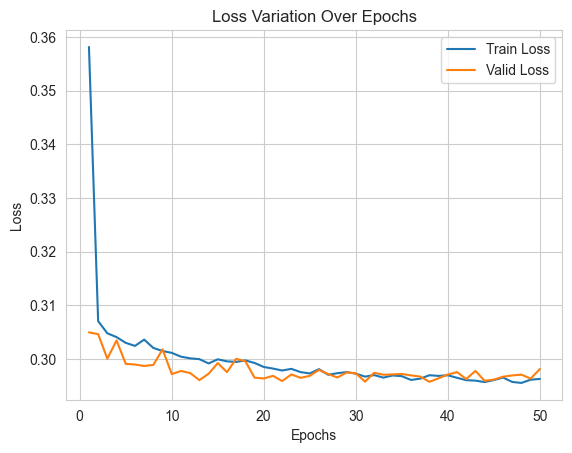

In [53]:
model = CNN()

# 定义损失函数和优化器
criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

batch_size = 256
epoch_num = 50

X_train = X_train.float()
y_train = y_train.float()
X_val = X_val.float()
y_val = y_val.float()

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train(model, train_loader, criterion, optimizer, scheduler=scheduler, val_loader=val_loader, epochs=epoch_num)

In [54]:
from sklearn.metrics import roc_auc_score

model = CNN()
model.load_state_dict(torch.load('CNN.pth'))

# 在验证循环中，获取模型输出的概率
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = outputs.squeeze()  # 去掉维度为1的维度，得到概率值
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 将列表转换为numpy数组
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 计算AUC值
auc_value = roc_auc_score(all_labels, all_preds)

print(f'AUC on validation set: {auc_value}')

AUC on validation set: 0.7610522390895444


In [55]:
import pandas as pd

# 将模型设为评估模式
model.eval()

# 使用 torch.no_grad() 确保在推理时不进行梯度计算
with torch.no_grad():
    test_outputs = model(X_test)
    preds = test_outputs.squeeze()

# 将索引和预测概率保存到 DataFrame
result_df = pd.DataFrame({'index': test_mask, 'predict': preds.cpu().numpy()})

# 将结果保存到 CSV 文件
result_df.to_csv('CNN.csv', index=False)